# Adversarial samples (dSprites)

**Author**: Maleakhi A. Wijaya  
**Description**:  
We attack the original dSprites dataset using adversarial shifts and visualise the results in this notebook.

In [10]:
# Load utilities functions
%run ../../scripts/dsprites_utils.py
%run ../../fgsm_adversarial.py

In [3]:
## Random seed
SEED = 20
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load dataset and model

This section loads subset of dSprites data and the end-to-end model that we will attack.

In [4]:
path = "../../data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
X_train, X_test, y_train, y_test, c_train, c_test = load_dsprites(path, 100000, DatasetTask.Task1, train_size=0.85, class_index=1)

Training samples: 85000
Testing samples: 15000


In [5]:
# Split into training, validation, and test
X_train, X_valid = X_train[:50000], X_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]
c_train, c_valid = c_train[:50000], c_train[50000:]

# Useful params
orig_dims = X_test.shape[1:]
labels = ["square", "ellipse", "heart"]

In [6]:
# Load model
model_path = "../../models/end_to_end_dsprites_task1"
end_to_end_model = tf.keras.models.load_model(model_path)

## FGSM

In this section, we fool the model and attack the test dataset using the FGSM adversarial. We store the resulting image in the repository (under data > adversarial_samples).

In [11]:
generate_adversarials(X_test, y_test, end_to_end_model, "dsprites", False, 
                      epsilon=0.1, n_plots=0, save=True)

100%|██████████| 15000/15000 [01:12<00:00, 207.23it/s]


### Visualisation
We load and visualise the adversarial patterns and the resulting adversarial images.

In [12]:
## Load adversarial images
X_adversarial = np.load("../../data/adversarial_samples/X_adversarial_dsprites.npy")
perturb = np.load("../../data/adversarial_samples/perturbations_dsprites.npy")

## Reshape
X_adversarial_orig = X_adversarial.reshape((-1, 64, 64, 1)) # reshape into original dimensions
perturb_orig = perturb.reshape((-1, 64, 64, 1)) # reshape into original dimensions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


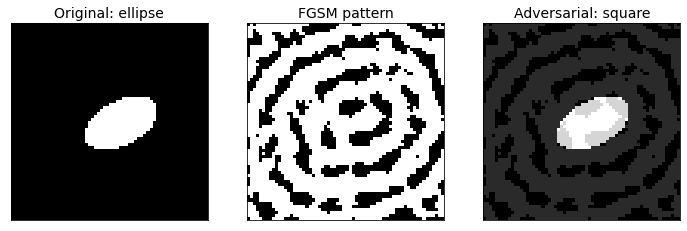

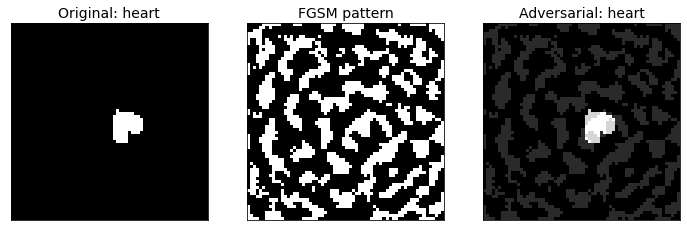

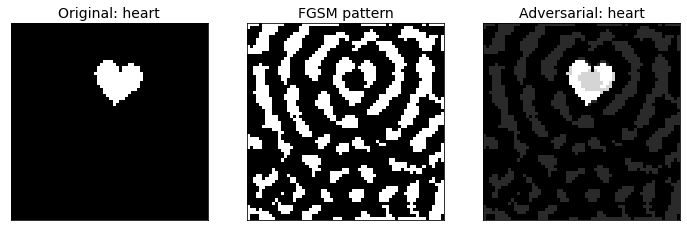

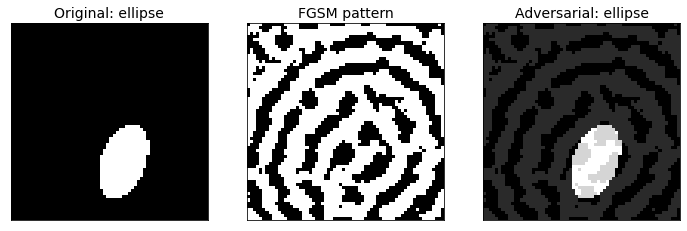

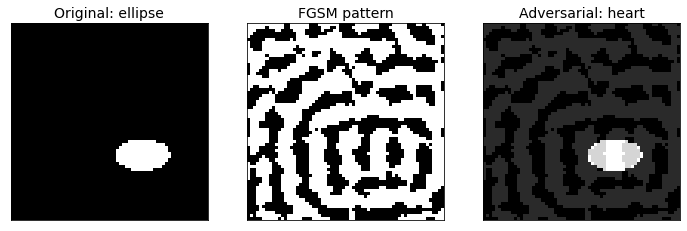

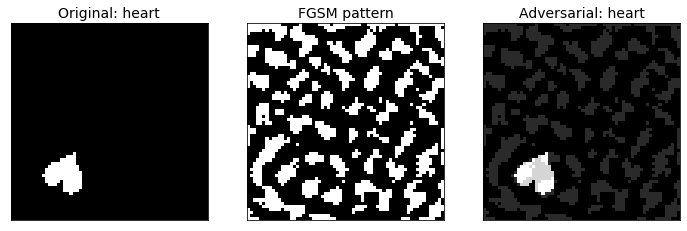

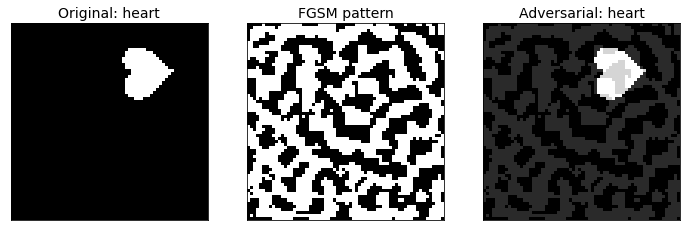

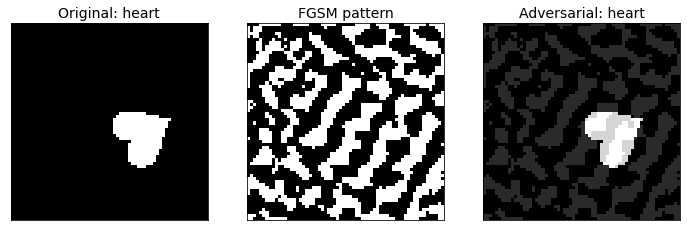

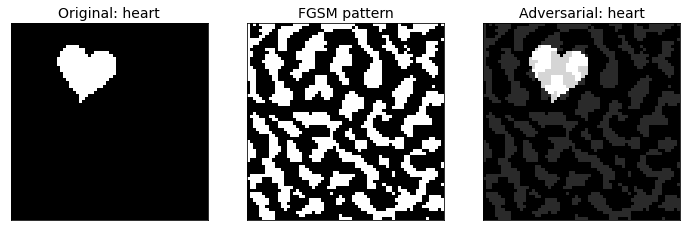

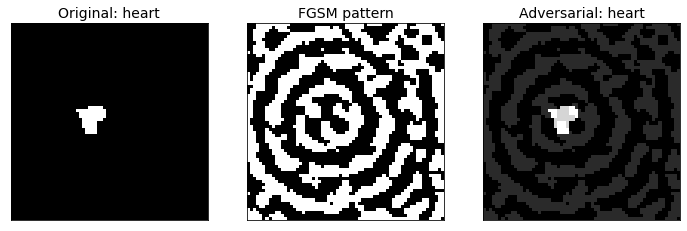

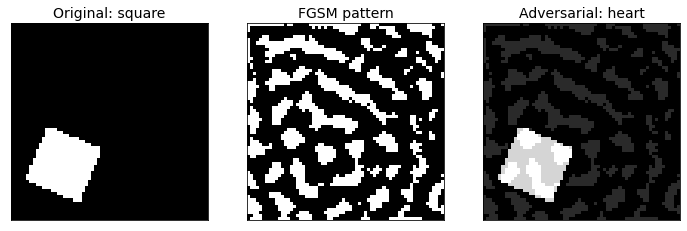

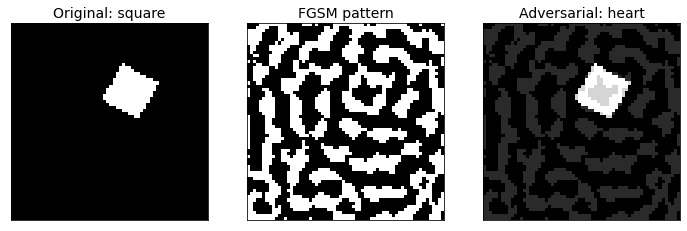

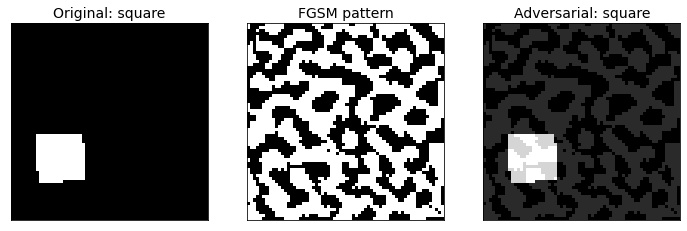

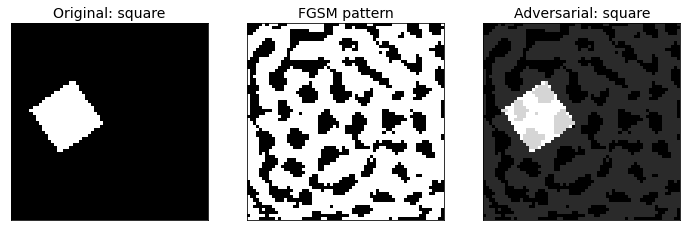

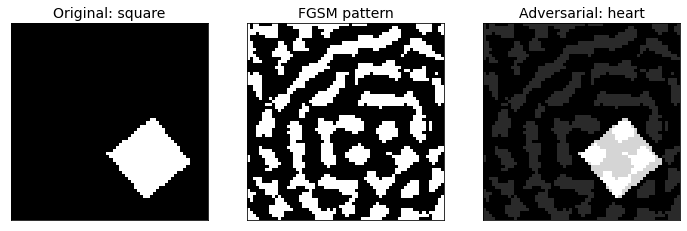

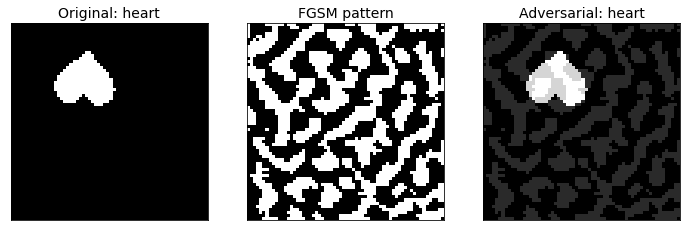

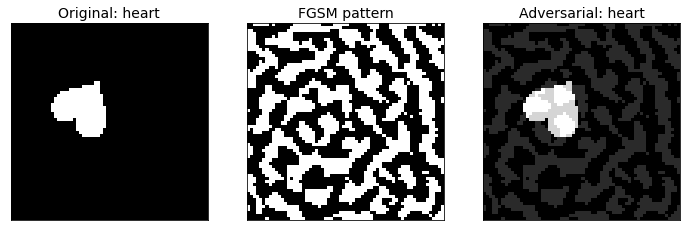

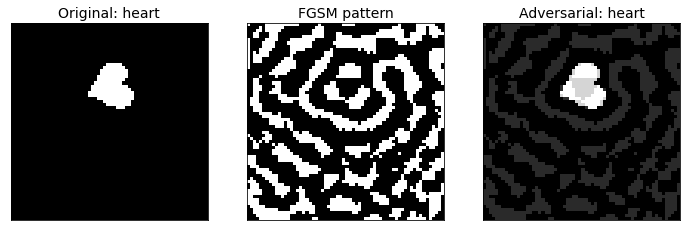

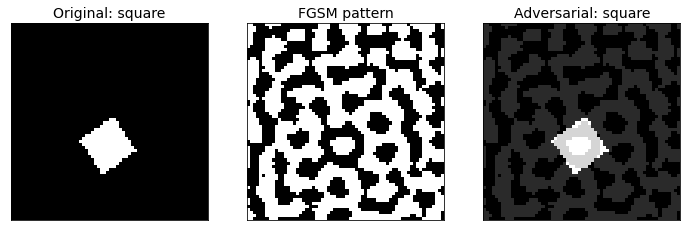

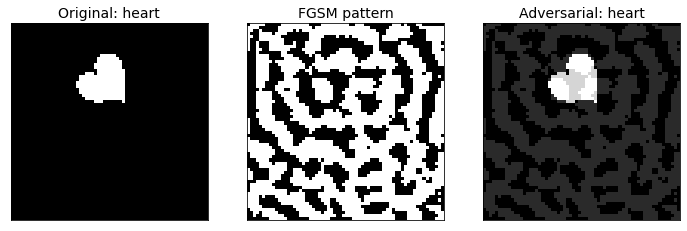

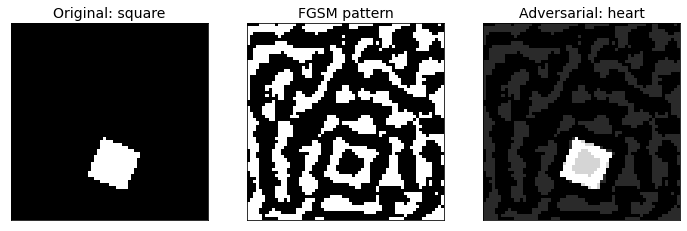

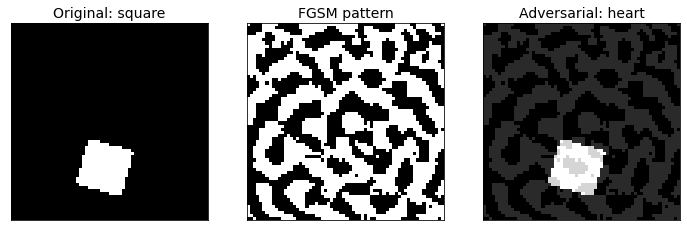

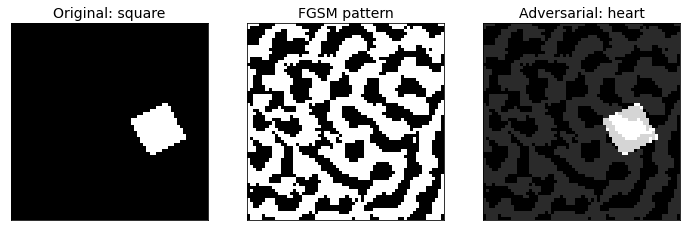

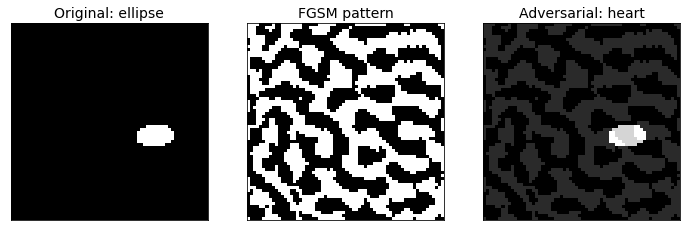

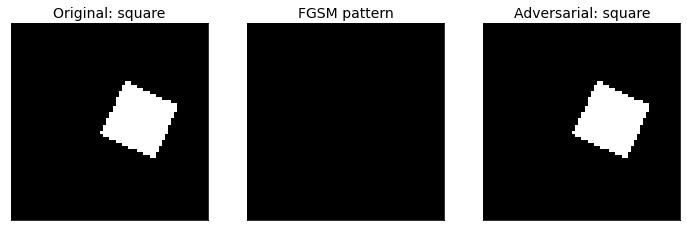

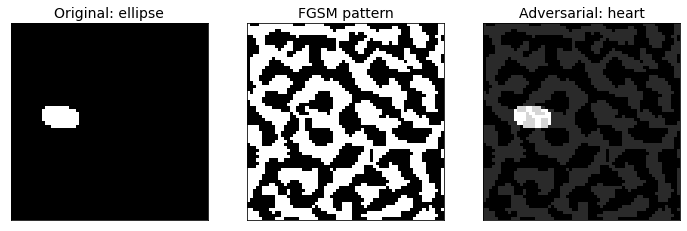

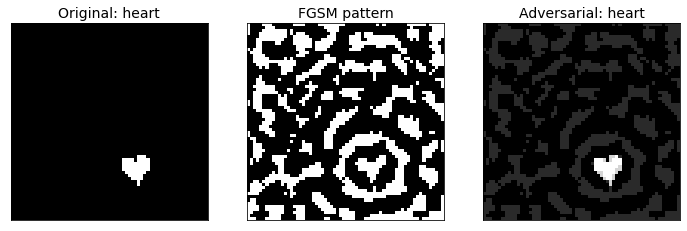

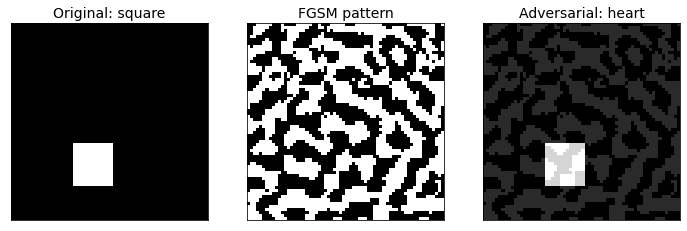

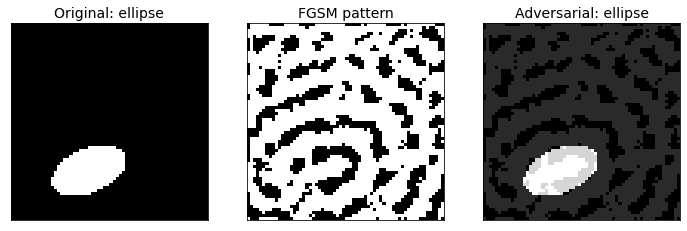

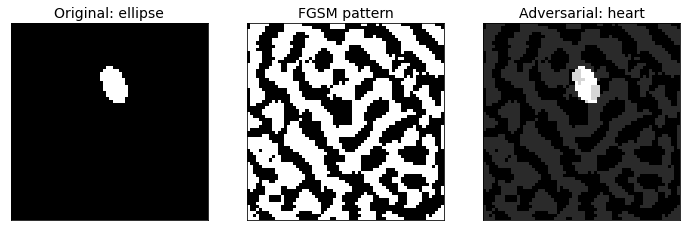

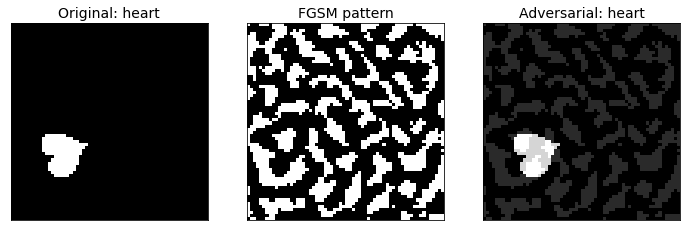

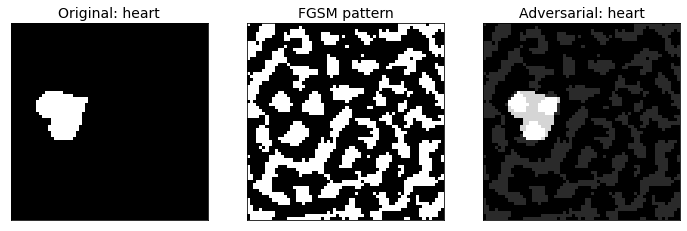

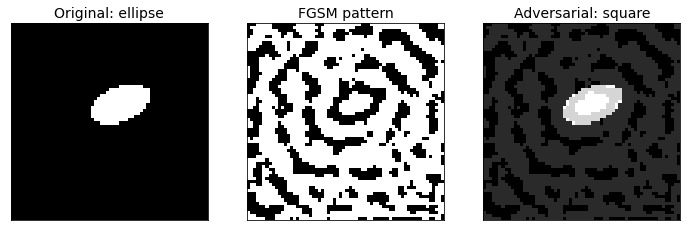

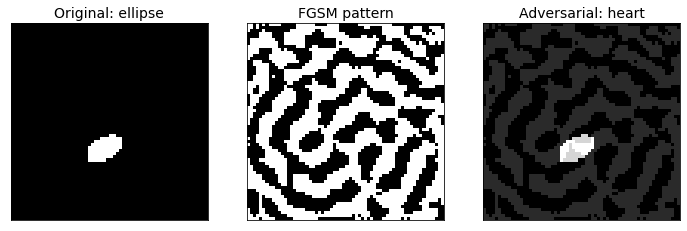

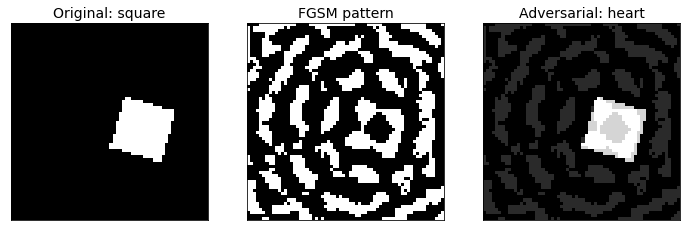

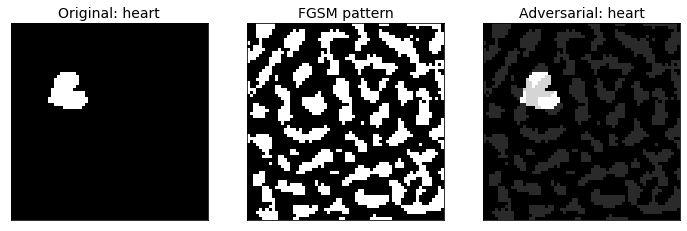

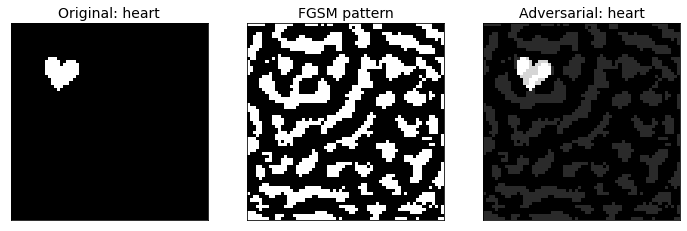

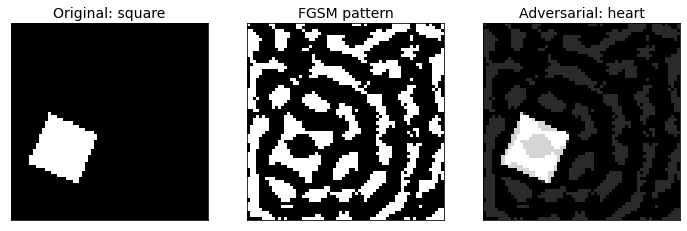

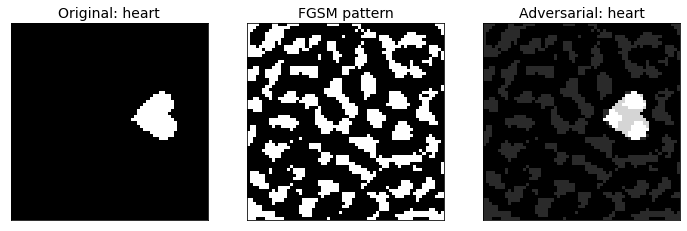

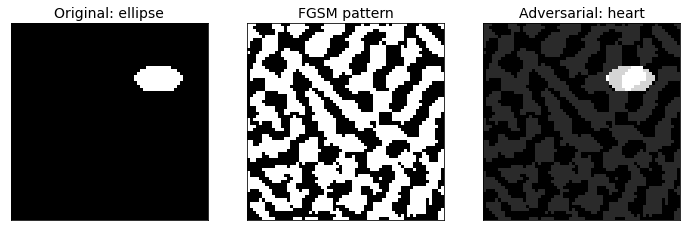

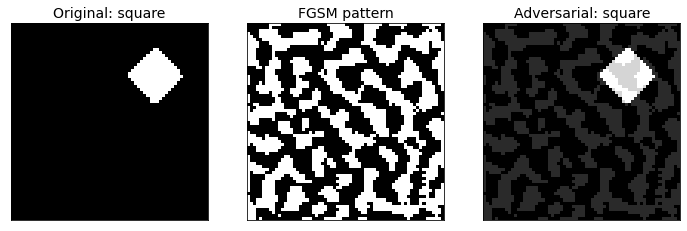

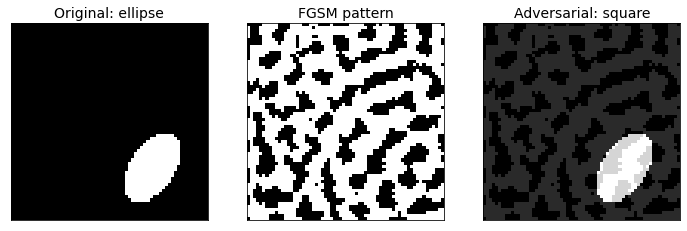

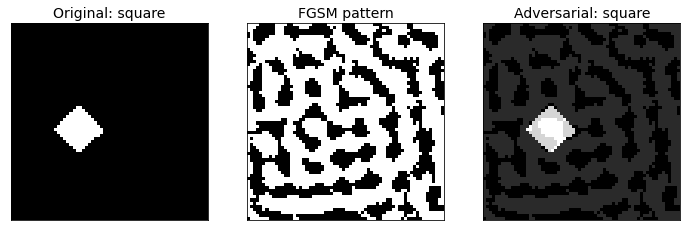

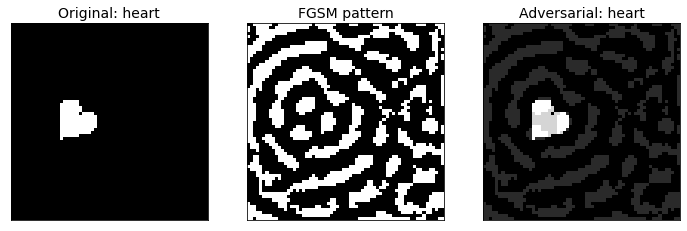

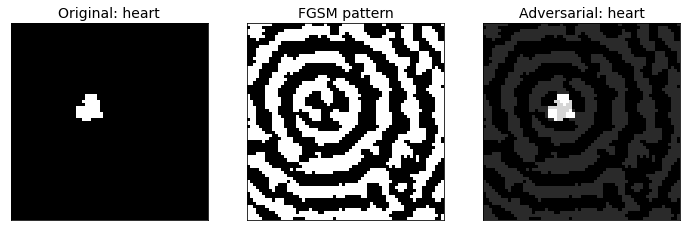

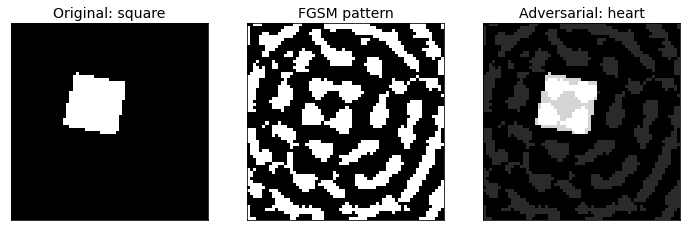

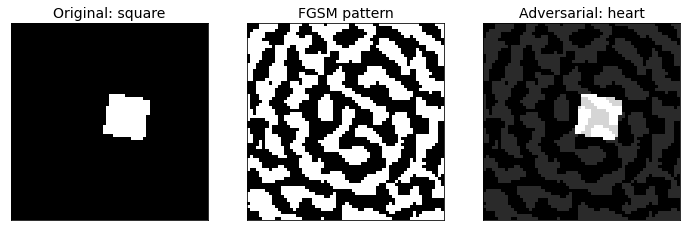

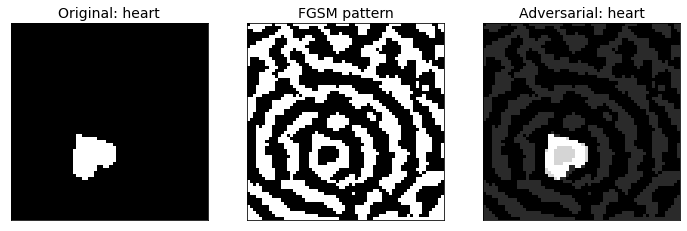

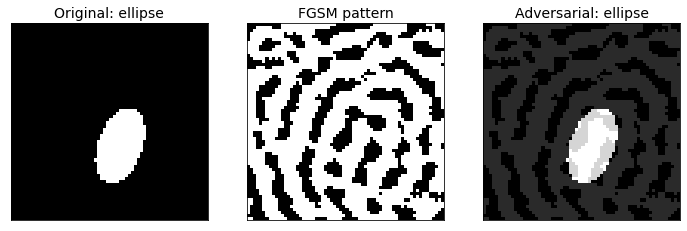

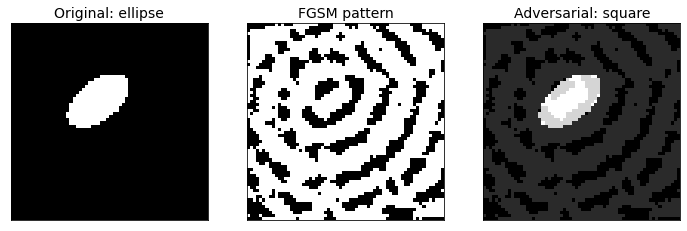

In [26]:
visualise_adversarial(X_test, perturb_orig, X_adversarial_orig, orig_dims,
                      end_to_end_model, labels, n_plots=50)

### Evaluation 

We calculate the before and after accuracy for the end-to-end and multitask models.

#### End-to-end model

**Before**

In [28]:
# Evaluate model (after)
y_pred = end_to_end_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5091
           1       1.00      1.00      1.00      5017
           2       1.00      1.00      1.00      4892

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



**After**

In [27]:
# Evaluate model (after)
y_pred = end_to_end_model.predict(X_adversarial_orig)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.32      0.44      5091
           1       0.97      0.46      0.62      5017
           2       0.47      1.00      0.64      4892

    accuracy                           0.59     15000
   macro avg       0.72      0.59      0.57     15000
weighted avg       0.72      0.59      0.57     15000



#### Multitask model

In [29]:
path = "../../models/multitask_dsprites"
mt_model = tf.keras.models.load_model(path)

**Before**

In [30]:
# Evaluate model
for i, pred in enumerate(mt_model.predict(X_test)):
    print("*"*20, f"Model: {DSPRITES_CONCEPT_NAMES[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pred = np.argmax(pred, axis=1)
    
    print(classification_report(c_truth, c_pred))
    print("\n\n")

******************** Model: color ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000




******************** Model: shape ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5091
           1       1.00      1.00      1.00      5017
           2       1.00      1.00      1.00      4892

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000




******************** Model: scale ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2476
           1       1.00      1.00      1.00      2536
           2

**After**

In [31]:
# Evaluate model
for i, pred in enumerate(mt_model.predict(X_adversarial_orig)):
    print("*"*20, f"Model: {DSPRITES_CONCEPT_NAMES[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pred = np.argmax(pred, axis=1)
    
    print(classification_report(c_truth, c_pred))
    print("\n\n")

******************** Model: color ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000




******************** Model: shape ********************
              precision    recall  f1-score   support

           0       0.92      0.31      0.46      5091
           1       0.85      0.58      0.69      5017
           2       0.49      1.00      0.66      4892

    accuracy                           0.62     15000
   macro avg       0.75      0.63      0.60     15000
weighted avg       0.76      0.62      0.60     15000




******************** Model: scale ********************
              precision    recall  f1-score   support

           0       0.36      0.61      0.45      2476
           1       0.32      0.46      0.38      2536
           2